In [1]:
from obspy import read
from obspy.core import UTCDateTime
import numpy as np
from matplotlib import mlab
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import math as M
import matplotlib
import requests
from lxml import html
import os
#import boto3

__Preprossesing file an pushing to S3__

In [2]:
# web craweler
mainurl = 'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/'
mainurlpage =requests.get(mainurl)
webpage = html.fromstring(mainurlpage.content)
suburl = webpage.xpath('//a/@href')

# This is exhaustive...
# FileNum = len(suburl)
FileNum = 8
timestep = 5 #save results every 5 seceonds (no overlap)

data_url_list = []
for filename in suburl[6:FileNum]:
    data_url_list.append(str(mainurl + filename[2:]))

In [3]:
# 15 minute duration, some redundancies; get 308 rather than 288
len(suburl)

302

In [4]:
#provide requisite credential to access S3 bucket
#client = boto3.client('s3',aws_access_key_id='',
#         aws_secret_access_key='')

# 'read' is very generic... could rename this obspy_read or something

# for data_url in data_url_list:
for data_url in data_url_list[0:1]:
    
    # Now we are looping over the .mseed files (5 minutes each) 
    #  (ok actually just the first one if we use [0:1])
    #  And this is getting cut into 5-second segments; so 12 x 5 = 60 outputs per seed file
    #  Further there are 12 x 24 = 288 seed files per day
    # 
    # HOWEVER!!!!
    # There is a little bit of overlap in the output files so the file count will be a bit higher
    
    # stream is effectively the five-minute-long .mseed audio file from the raw data website
    stream = read(data_url)         # Read from url
    samp_rate = stream[0].stats.sampling_rate
    t_start = stream[0].stats.starttime
    t_end = stream[0].stats.endtime
    duration = t_end-t_start

    # Ping Detections
    # We believe these are about 1.25 seconds apart

    pingtimes = np.zeros(int(duration)-1)
    for stratpoint in range(int(duration)-1):
        pingindex = np.argmax(stream[0].data[int(stratpoint * samp_rate):int((stratpoint + 1) * samp_rate)])
        pingtimes[stratpoint] = (t_start + stratpoint + pingindex * stream[0].stats.delta)

    # Filter Data+Plot Spectrogram+Save Image and Audio 

    def _nearest_pow_2(x):
        a = M.pow(2, M.ceil(np.log2(x)))
        b = M.pow(2, M.floor(np.log2(x)))
        if abs(a - x) < abs(b - x):
            return a
        else:
            return b
        
    # step_size = 5 translates to 5 seconds of data in what follows
    step_size = 5 # for calculating the rms pressure and ploting the spectrogram 
    wlen = 0.056;  # bin size in sec 
    nfft = int(_nearest_pow_2(wlen * samp_rate))  # number of fft points of each bin

    per_lap = 0.995      # percentage of overlap
    nlap = int(nfft * float(per_lap))   # number of overlapped samples

    for i in range(0, len(pingtimes), timestep):
        
        # obspy's smallest workable integer unit is seconds here; hence step_size = 5 gives a 5 sec window
        st = stream.slice(UTCDateTime(pingtimes[i]), UTCDateTime(pingtimes[i]) + step_size)
        
        # Plot Spectrogram
        npts = len(st[0])
        end = npts / samp_rate
        
        # using mlab to create the array of spectrogram 
        specgram, freq, time = mlab.specgram(st[0].data/1e-6, NFFT = nfft, Fs = samp_rate, noverlap = nlap, pad_to = None)
        specgram = 10 * np.log10(specgram[1:, :])
        specgram = np.flipud(specgram)
        freq = freq[1:] / 1e3  # Convert Frequency to kHz
        halfbin_time = (time[1] - time[0]) / 2.0
        halfbin_freq = (freq[1] - freq[0]) / 2.0
        freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
        time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
        extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                      freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
        
        # colormap setting
        vmin = 0.50  # default should be 0 to start from the min number of the spectrgram
        vmax = 0.95  # default should be 1 to end at the max number of the spectrgram
        _range = float(specgram.max() - specgram.min())
        vmin = specgram.min() + vmin * _range
        vmax = specgram.min() + vmax * _range
        norm = Normalize(vmin, vmax)  # to scale a 2-D float X input to the (0, 1) range for input to the cmap

# This section commented out as multiple .mseed source files will eventually crash the notebook with plots...

#         # plot spectrogram
#         fig = plt.figure(figsize=(8,8))
#         ax = fig.add_subplot(111)
#         cax = ax.imshow(specgram, interpolation="nearest", extent=extent, norm=norm, cmap='viridis')
#         dpi = fig.get_dpi()
#         fig.set_size_inches(512/float(dpi),512/float(dpi))
#         ax.axis('tight')
#         ax.set_xlim(0, end)
#         ax.set_ylim(0,11)
#         ax.grid(False)
#         ax.set_xlabel('Time [s]')
#         ax.set_ylabel('Frequency [kHz]')

        # Save spectrogram
        fig = plt.figure(frameon=False, figsize=(8,8))
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        cax = ax.imshow(specgram, interpolation="nearest", extent=extent, norm=norm, cmap='viridis')
        dpi = fig.get_dpi()
        fig.set_size_inches(512/float(dpi),512/float(dpi))
        ax.axis('tight')
        ax.set_xlim(0, end)
        ax.set_ylim(0,11)
        ax.grid(False)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [kHz]')
        filename = st[0].stats.network+'_'+st[0].stats.station+'_'+st[0].stats.location+'_'+st[0].stats.channel+'_'+str(UTCDateTime(pingtimes[i])).replace("-","_").replace(":","_")

        # These three lines save the figure to disk, then push to S3, then delete; notice they are commented out
        #   See comment below on timestamp characters
        # plt.savefig(filename[:-8] + '.jpg')
        # client.upload_file(filename[:-8] + '.jpg', 'himatdata', 'whaledr/'+ filename[:-8] + '.jpg')
        # os.remove(filename[:-8] + '.jpg')
        
        # Rather: At this point we could create a temporary memory object and write that to S3
        # to be done...
        
        
        # First garbage-collect (clf()) and *then* close it to properly clean up (avoid a memory leak)
        plt.clf()
        plt.close(fig)
        
        #save audio
        def Save2Wav(sound):
            sound = sound.copy()
            sound.normalize()
            sound.data = (sound.data * (2**31-1)).astype('int32')
            sound.write(filename[:-8] + '.wav', format = 'WAV', framerate = samp_rate)
            
        Save2Wav(st[0])
        
        # Notice [:-8] which tosses out 8 timestamp characters, not needed for anything
        #client.upload_file(filename[:-8] + '.wav', 'himatdata', 'whaledr/'+ filename[:-8] + '.wav')
        os.remove(filename[:-8] + '.wav')

C:\Users\ganzk\Anaconda3\lib\site-packages\obspy\core\trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


In [10]:
from obspy import read
ms = read("C:/users/ganzk/Desktop/notebooks/dev_notebooks/keenan/whales/negative.mseed")[0]
print(ms)

OO.HYVM1..YDH | 2017-10-06T00:00:00.000000Z - 2017-10-06T00:04:59.997984Z | 64000.0 Hz, 19199872 samples


In [11]:
ms.stats

         network: OO
         station: HYVM1
        location: 
         channel: YDH
       starttime: 2017-10-06T00:00:00.000000Z
         endtime: 2017-10-06T00:04:59.997984Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 19199872
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 6604, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 27049984})

In [15]:
lis = ms.data.tolist()

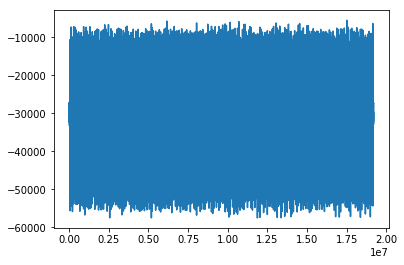

In [17]:
from matplotlib import pyplot as plt

plt.plot(lis)

In [18]:
ms = read("C:/users/ganzk/Desktop/notebooks/dev_notebooks/keenan/whales/positive.mseed")[0]
print(ms)

OO.HYVM1..YDH | 2017-10-06T19:00:00.000015Z - 2017-10-06T19:04:59.997999Z | 64000.0 Hz, 19199872 samples


In [19]:
lis = ms.data.tolist()

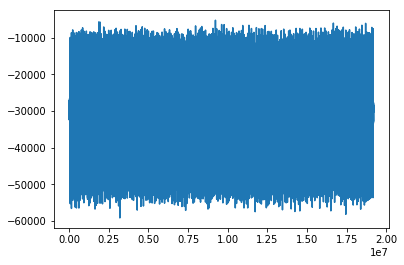

In [20]:
plt.plot(lis)